In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import glob
import warnings
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import graphviz
import shap

file_dir = '/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

# drop first N hours of data in each wrfstat file
spin_up = 3

# get data capped at height level
lev_i = 8

In [2]:
def get_features(file_num, lev_i):

    features_df = pd.DataFrame()
    
    print('#################### wrfstat'+str(file_num)+' ####################')
    print()

    for wfile in glob.glob(file_dir+'wrfstat'+str(file_num)+'*'): 

        wrfstat = xr.open_dataset(wfile)

        wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

        time_thres = wrfstat['XTIME'].min().values + np.timedelta64(spin_up, 'h')

        wrfstat = wrfstat.where(wrfstat['XTIME'] >= time_thres, drop=True)
        
        def get_tminus_df(var, minus_i):
    
            var_df = xr.concat([wrfstat[var][0:minus_i, 0:lev_i]*np.NaN, 
                                wrfstat[var][0:, 0:lev_i]], dim='Time').to_dataframe(var+'_t-'+str(minus_i))

            return var_df

        combine_df = reduce(
            lambda left, right: pd.merge(left, right, left_index=True, right_index=True), 
            [wrfstat['CSP_WS'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_WS', 1), get_tminus_df('CSP_WS', 2),
    #          wrfstat['CSP_U'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_U', 1), get_tminus_df('CSP_U', 2),
    #          wrfstat['CSP_V'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_V', 1), get_tminus_df('CSP_V', 2),
             wrfstat['CSP_W'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_W', 1), get_tminus_df('CSP_W', 2), 
             wrfstat['CSP_P'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_P', 1), get_tminus_df('CSP_P', 2),
             wrfstat['CSP_THDT_LS'][:, 0:lev_i].to_dataframe(), 
             get_tminus_df('CSP_THDT_LS', 1), get_tminus_df('CSP_THDT_LS', 2),
             wrfstat['CSP_QVDT_LS'][:, 0:lev_i].to_dataframe(), 
             get_tminus_df('CSP_QVDT_LS', 1), get_tminus_df('CSP_QVDT_LS', 2)])

        features_df = features_df.append(combine_df.unstack())

    features_df.dropna(inplace=True)

    new_col, hgt_list = [], np.empty(0)

    for col in features_df.columns.values: 

        lev = int(wrfstat['CSP_Z'][0][col[1]].values)
        new_col.append(col[0]+'_'+str(lev)+'m')
        hgt_list = np.append(hgt_list, lev)

    features_df.columns = new_col
    hgt_list = np.unique(hgt_list)
    
    return features_df, hgt_list

def run_ml(target_hgt):
    
    print('height:', int(target_hgt), 'm')
    print()

    x_df = features_df.copy(deep=True)

    for h in hgt_list:
        if h >= target_hgt: 
            x_df = x_df[x_df.columns[(x_df.columns.str.contains(str(int(h))) == False)]]

    ws_lev = features_df.columns[(features_df.columns.str.contains('CSP_WS') == True) 
                                 & (features_df.columns.str.contains(str(int(target_hgt))) == True) 
                                 & (features_df.columns.str.contains('-') == False)]
    y = features_df[ws_lev]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.4, random_state=1)
    # print(X_train.shape, X_test.shape)

    ##### xgboost

    xgbregressor = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=4,
        subsample=0.8,
    )

    xgbregressor.fit(X_train, y_train)

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=UserWarning)
        y_pred_xgbr = xgbregressor.predict(X_test)
        
    mse_xgbr = np.round(mean_squared_error(y_test, y_pred_xgbr), 5)

    ##### random forest

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=2,
        min_samples_leaf=1,
    #     bootstrap=True
    )

    rf.fit(X_train, np.ravel(y_train))

    y_pred_rf = rf.predict(X_test)

    explainer = shap.TreeExplainer(rf)
    shap_rf = explainer.shap_values(X_test)
    
    mse_rf = np.round(mean_squared_error(y_test, y_pred_rf), 5)

    ##### power law

    x_df = X_test.copy(deep=True)

    u_col = x_df.columns[(x_df.columns.str.contains('CSP_WS') == True) 
                         & (x_df.columns.str.contains('-') == False)]

    lev_list = np.empty(0)

    for u_lev in u_col: 

        lev = u_lev.split('_')[-1].replace('m', '')

        lev_list = np.append(lev_list, float(lev))

    if (target_hgt < lev_list).sum() == 0: 

        levs = np.sort(lev_list)[-2:]

        alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
                /np.log(levs[1]/levs[0])

        x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']\
                                                   *(target_hgt/levs[1])**alpha
        
    mse_pl = np.round(mean_squared_error(y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']), 5)

    print('MSE:')
    print('XGBoost:', mse_xgbr)
    print('random forest:', mse_rf)
    print('power law: ', mse_pl)

    fig, ax = plt.subplots(figsize=(6, 3))
    xgb.plot_importance(xgbregressor, ax=ax, max_num_features=10, grid=False, 
                        title='XGBoost Regression feature importance')
    plt.show()

    shap.summary_plot(shap_rf, X_test, plot_type='bar', max_display=10, plot_size=(6, 3))
    
    return mse_xgbr, mse_rf, mse_pl

#################### wrfstat1 ####################

height: 77 m

MSE:
XGBoost: 0.00308
random forest: 0.04932
power law:  1.21862


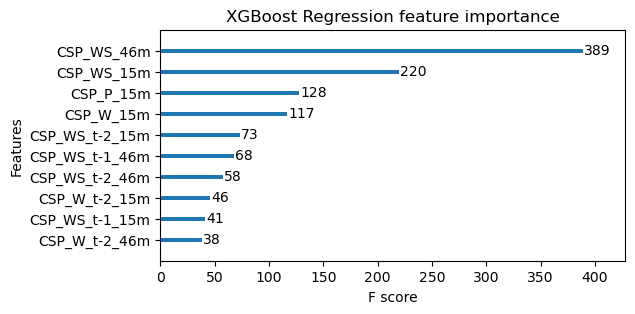

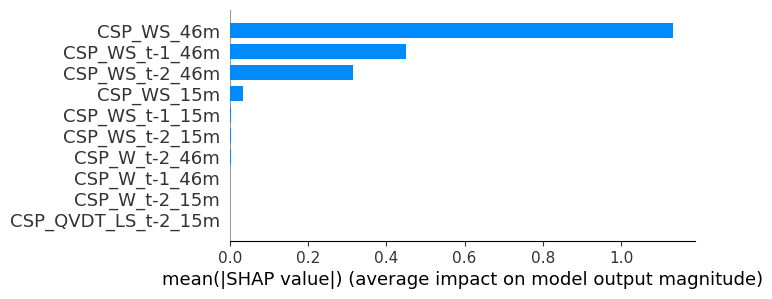

height: 108 m

MSE:
XGBoost: 0.0013
random forest: 0.02129
power law:  0.02662


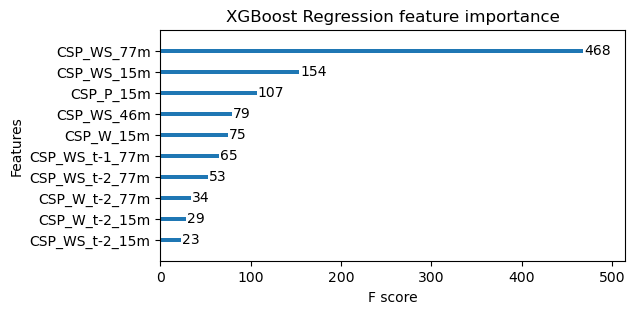

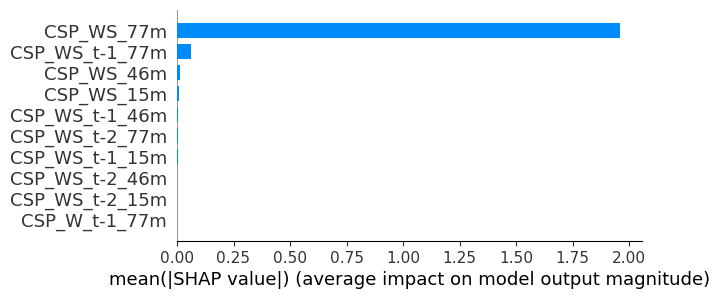

height: 139 m

MSE:
XGBoost: 0.00112
random forest: 0.01841
power law:  0.00186


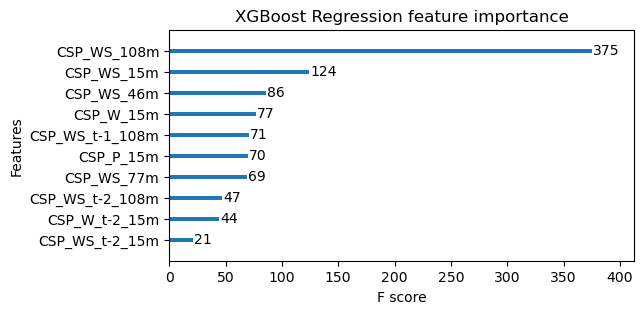

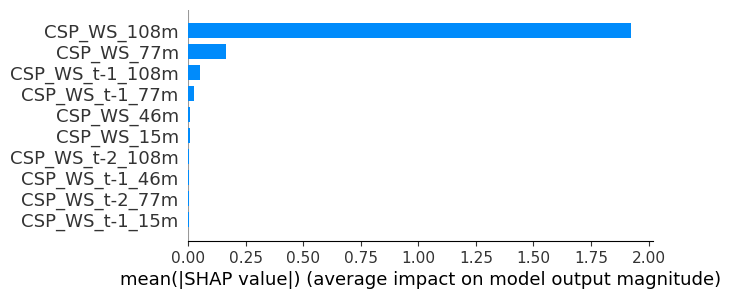

height: 169 m

MSE:
XGBoost: 0.00092
random forest: 0.01839
power law:  0.00029


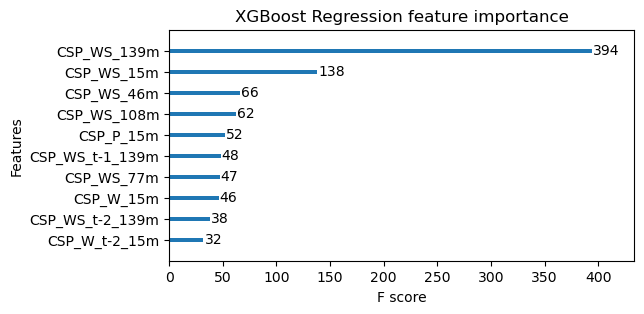

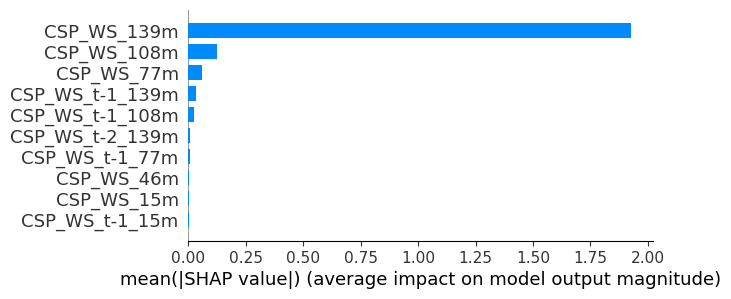

height: 200 m

MSE:
XGBoost: 0.00073
random forest: 0.01736
power law:  0.00022


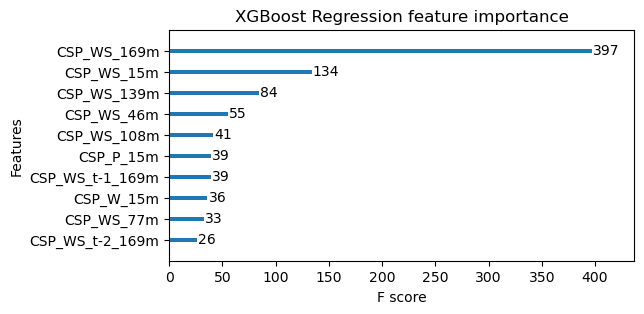

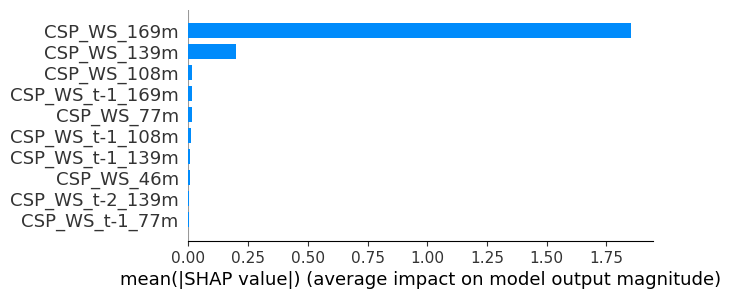

height: 231 m

MSE:
XGBoost: 0.00088
random forest: 0.01802
power law:  7e-05


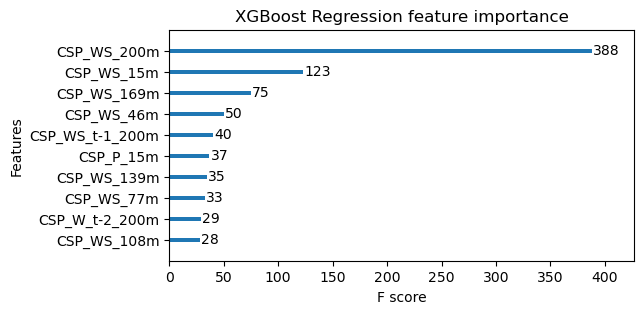

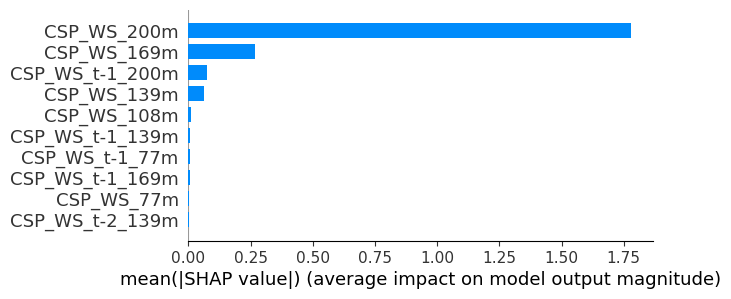

#################### wrfstat2 ####################

height: 78 m

MSE:
XGBoost: 0.00351
random forest: 0.04176
power law:  0.80062


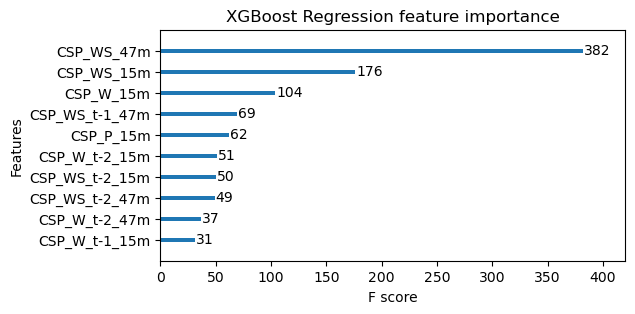

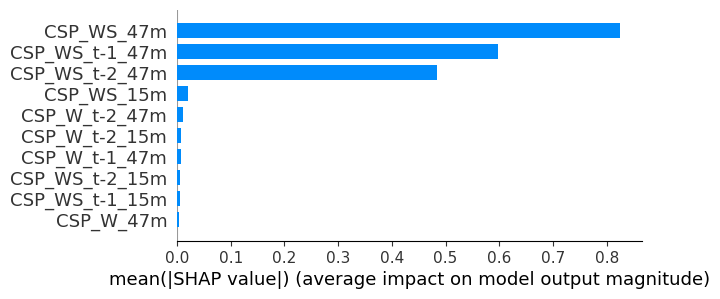

height: 108 m

MSE:
XGBoost: 0.00125
random forest: 0.02336
power law:  0.02623


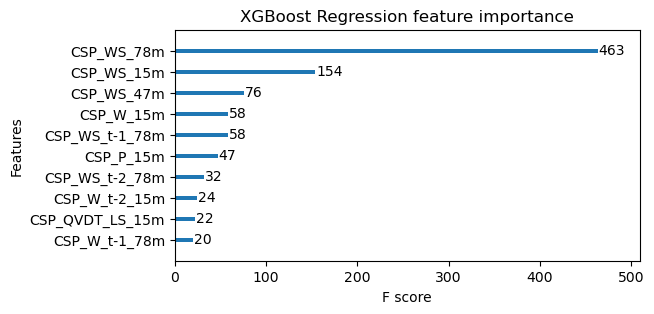

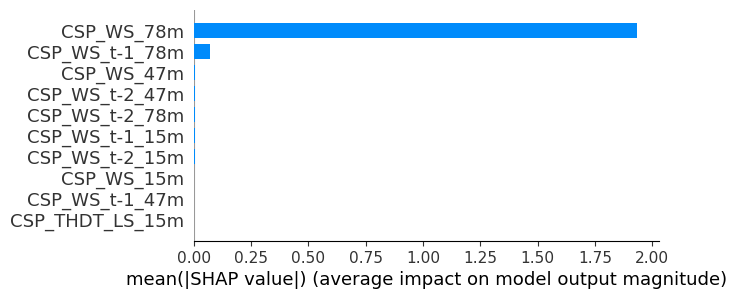

height: 139 m

MSE:
XGBoost: 0.00121
random forest: 0.01962
power law:  0.00268


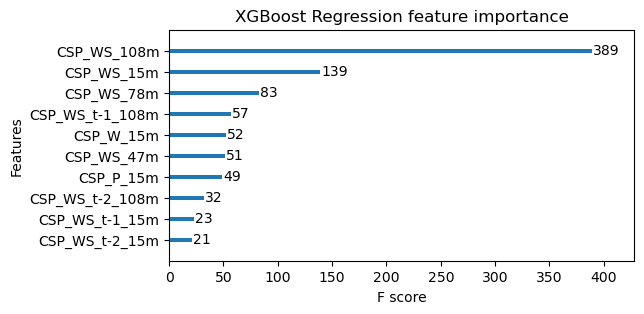

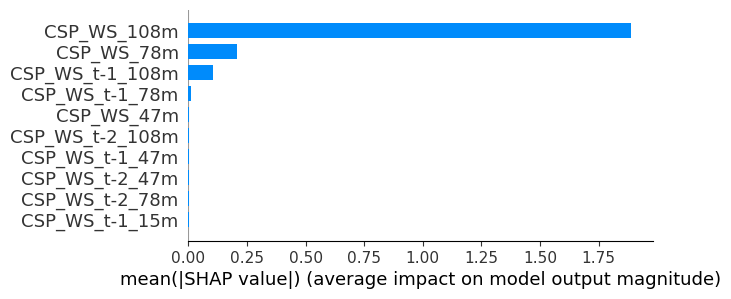

height: 170 m

MSE:
XGBoost: 0.0009
random forest: 0.02286
power law:  0.00043


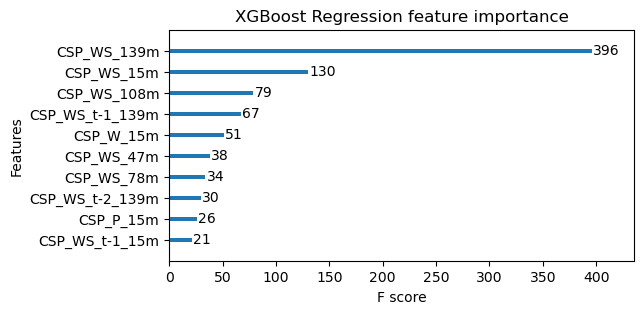

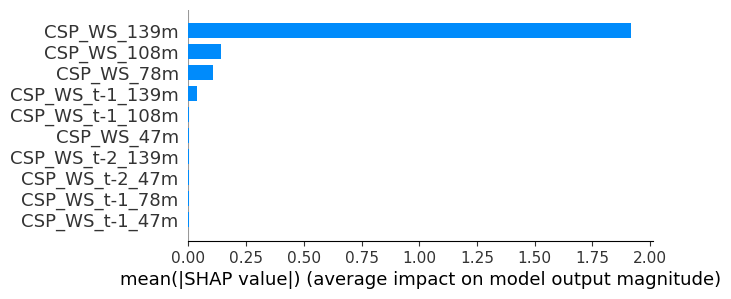

height: 201 m

MSE:
XGBoost: 0.00091
random forest: 0.02232
power law:  0.00017


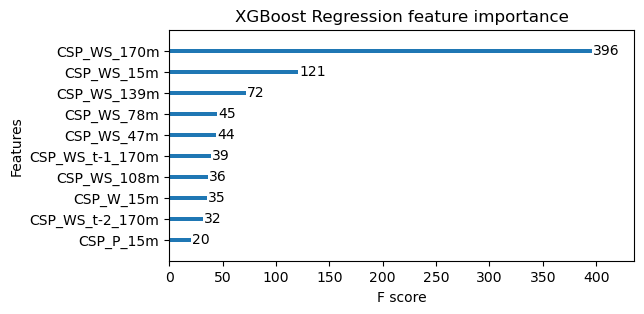

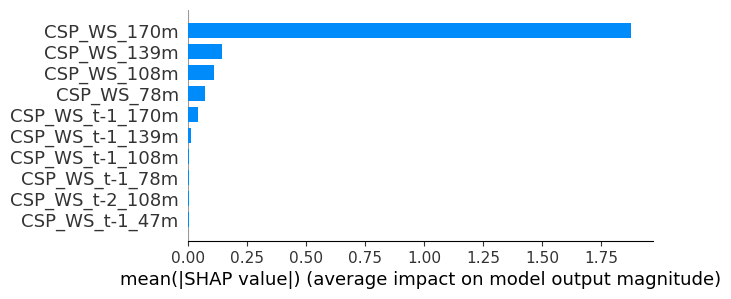

height: 231 m

MSE:
XGBoost: 0.00084
random forest: 0.02126
power law:  6e-05


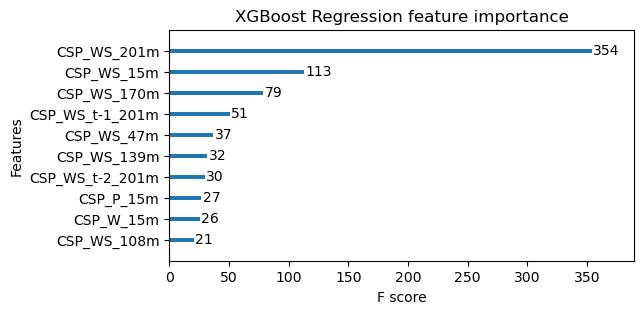

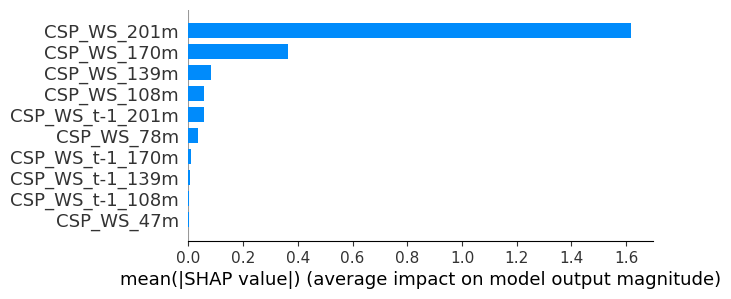

#################### wrfstat3 ####################

height: 77 m

MSE:
XGBoost: 0.00416
random forest: 0.04799
power law:  0.98558


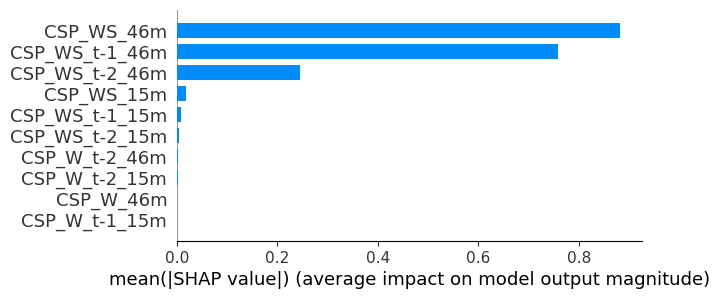

height: 108 m

MSE:
XGBoost: 0.00218
random forest: 0.02341
power law:  0.02621


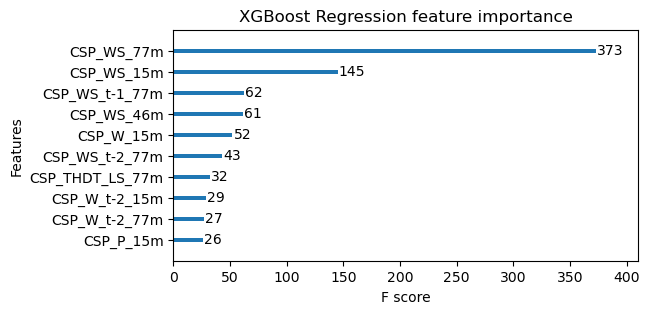

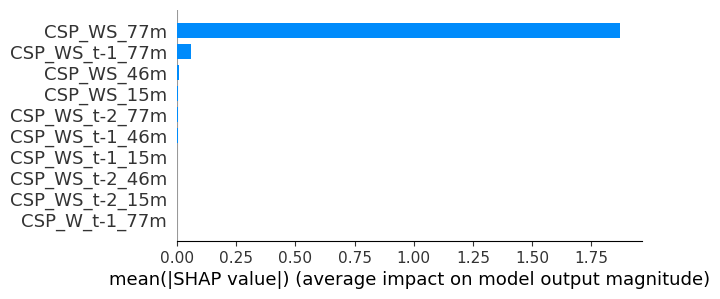

height: 139 m

MSE:
XGBoost: 0.0019
random forest: 0.02304
power law:  0.00213


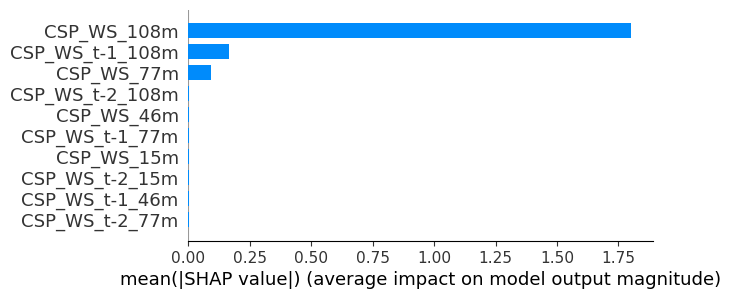

height: 170 m

MSE:
XGBoost: 0.00177
random forest: 0.02262
power law:  0.00043


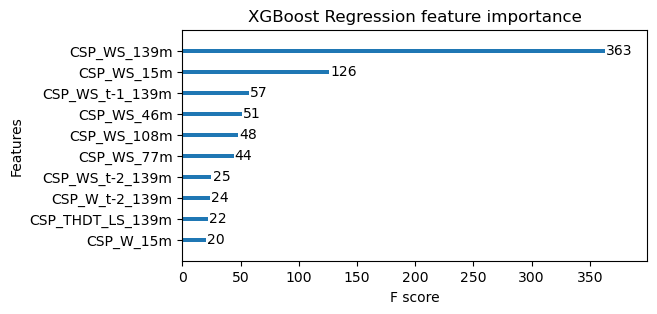

height: 201 m

MSE:
XGBoost: 0.00156
random forest: 0.01991
power law:  0.00016


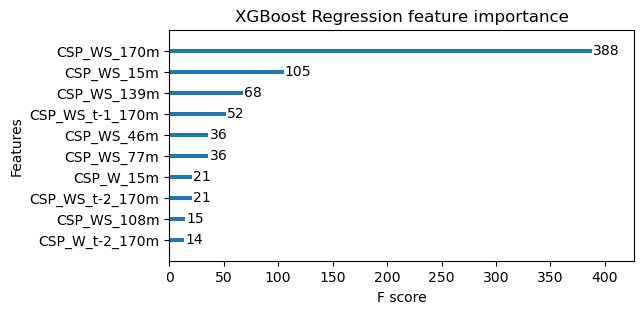

height: 232 m

MSE:
XGBoost: 0.00161
random forest: 0.01882
power law:  8e-05


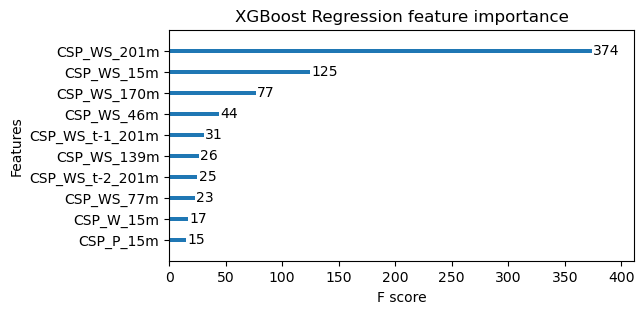

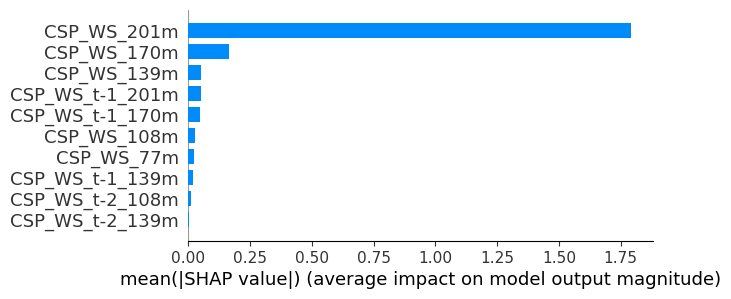

#################### wrfstat4 ####################

height: 78 m

MSE:
XGBoost: 0.00301
random forest: 0.04362
power law:  0.8257


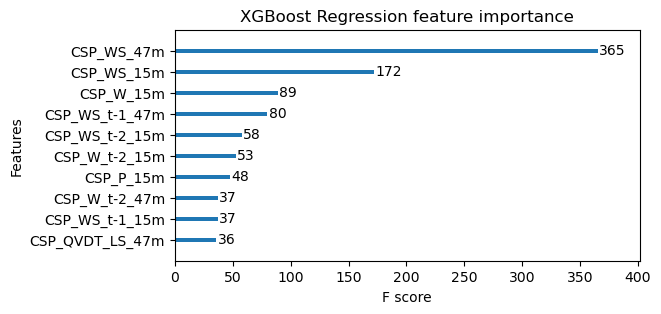

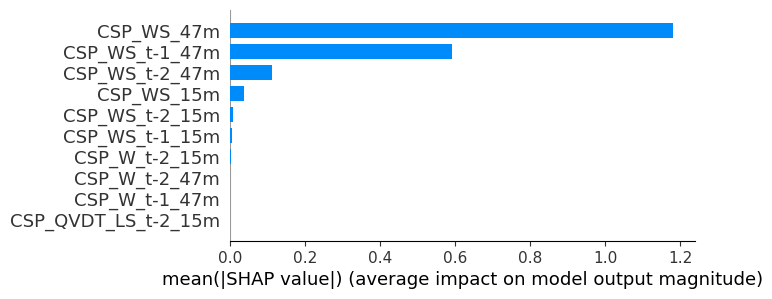

height: 109 m

MSE:
XGBoost: 0.00188
random forest: 0.02284
power law:  0.02475


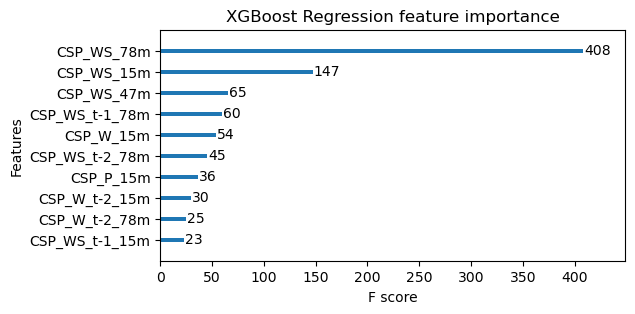

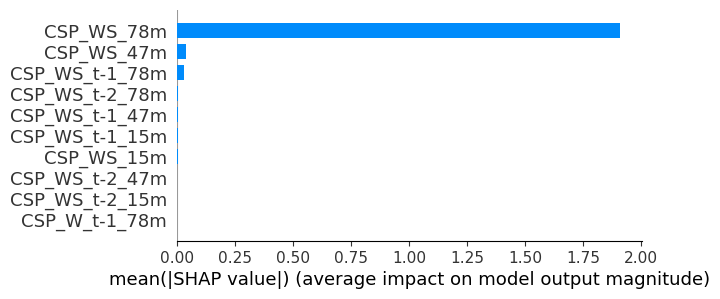

height: 139 m

MSE:
XGBoost: 0.0018
random forest: 0.02147
power law:  0.00197


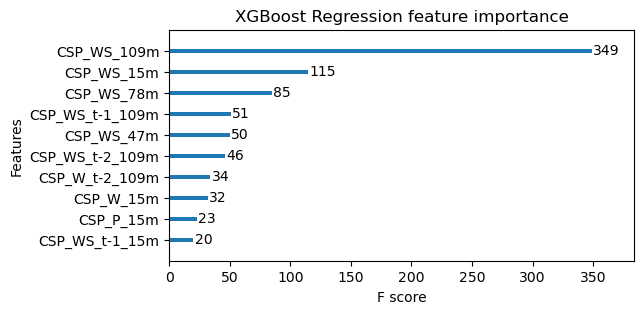

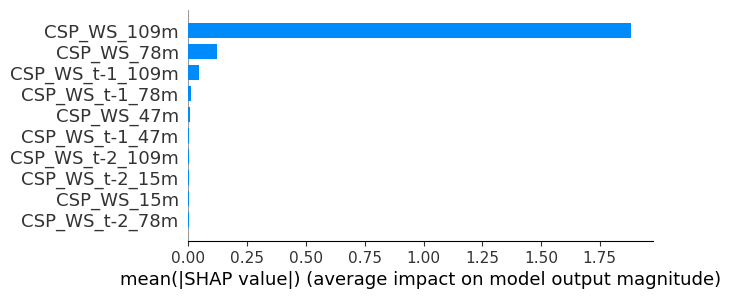

height: 170 m

MSE:
XGBoost: 0.00154
random forest: 0.01813
power law:  0.00059


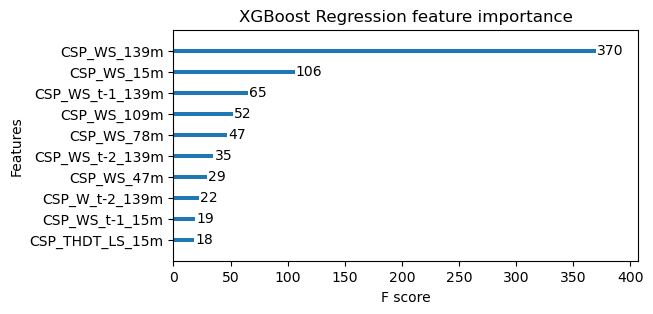

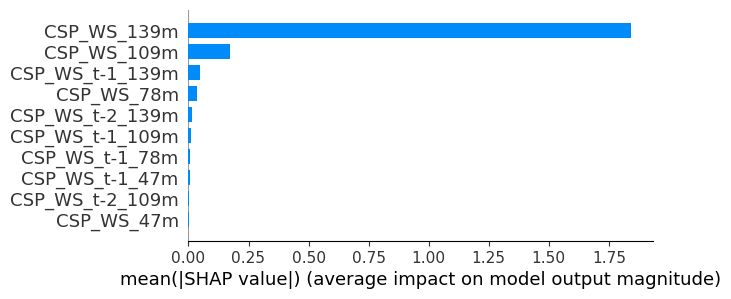

height: 201 m

MSE:
XGBoost: 0.00115
random forest: 0.01935
power law:  0.00016


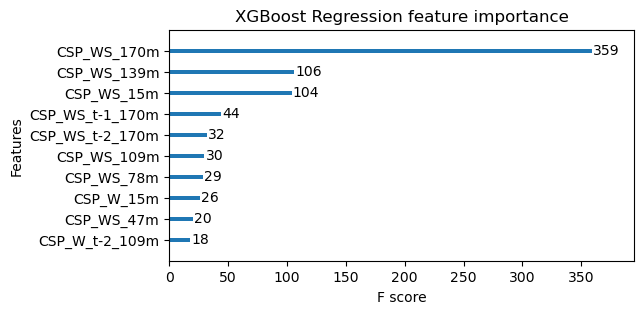

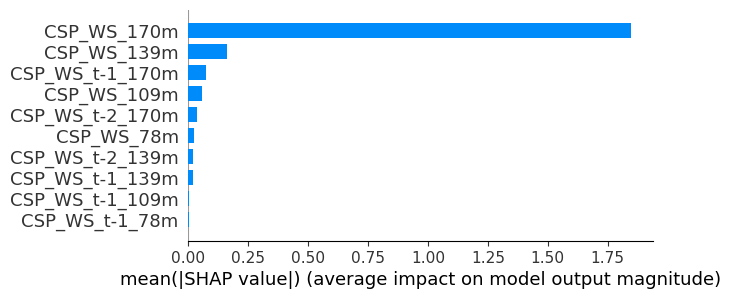

height: 231 m

MSE:
XGBoost: 0.00111
random forest: 0.01841
power law:  6e-05


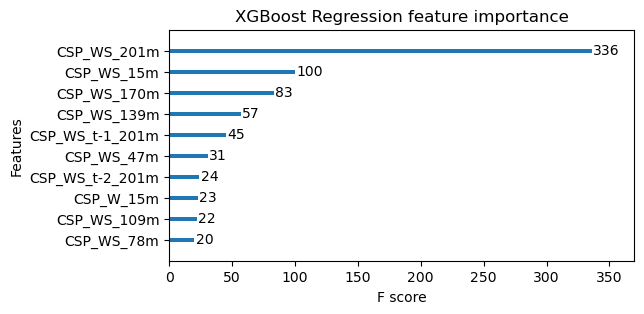

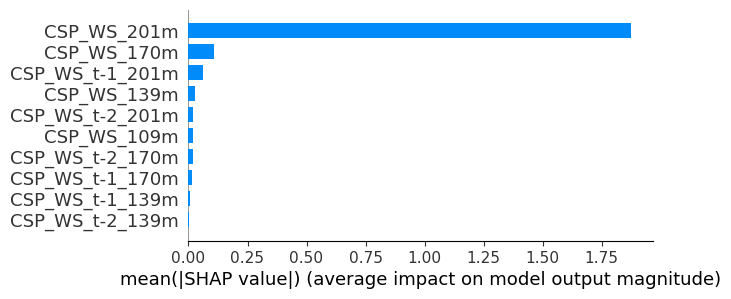

#################### wrfstat5 ####################

height: 78 m

MSE:
XGBoost: 0.00395
random forest: 0.03866
power law:  0.63695


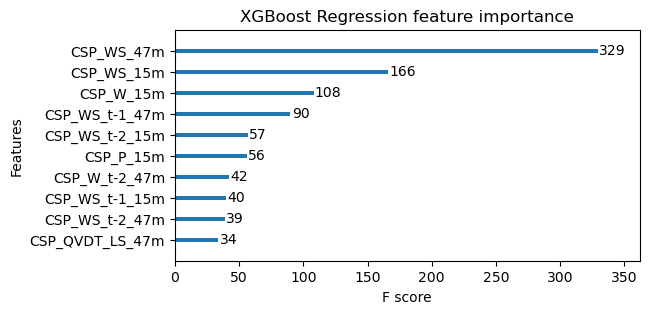

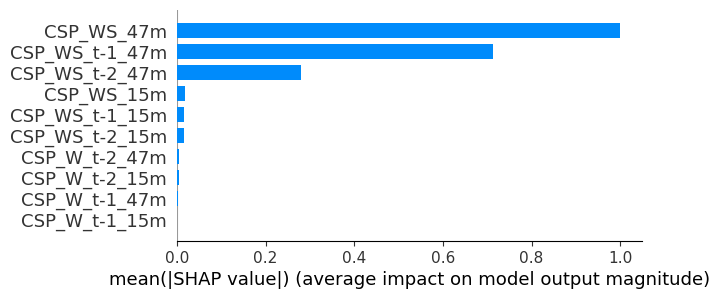

height: 109 m

MSE:
XGBoost: 0.00223
random forest: 0.02092
power law:  0.02217


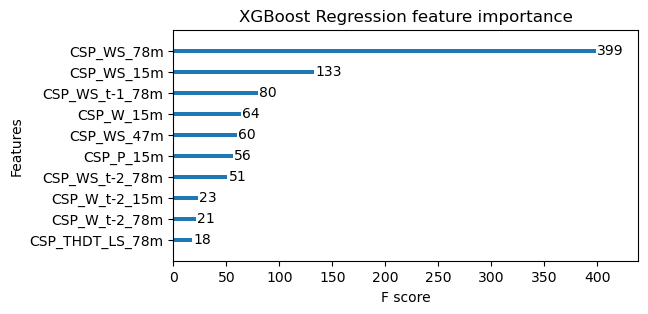

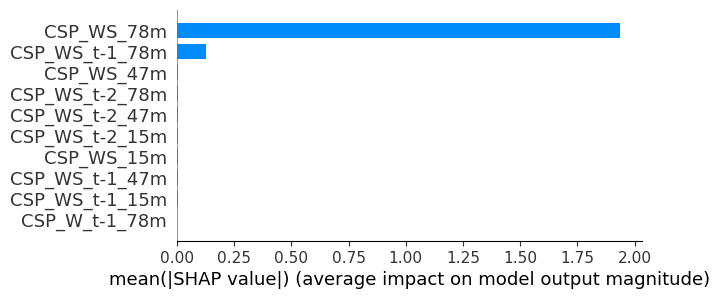

height: 140 m

MSE:
XGBoost: 0.00199
random forest: 0.02035
power law:  0.00196


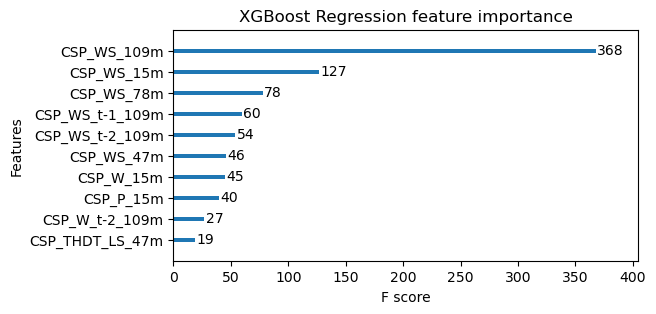

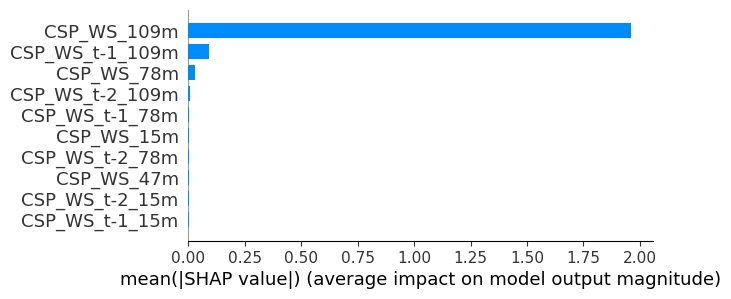

height: 172 m

MSE:
XGBoost: 0.002
random forest: 0.02157
power law:  0.0005


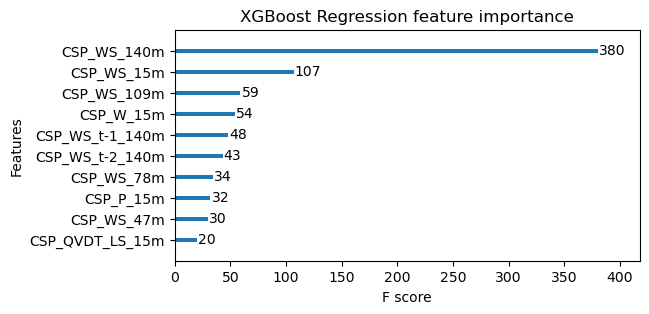

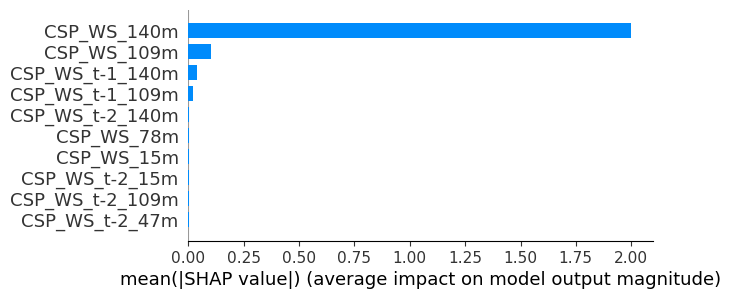

height: 203 m

MSE:
XGBoost: 0.00197
random forest: 0.02036
power law:  0.00011


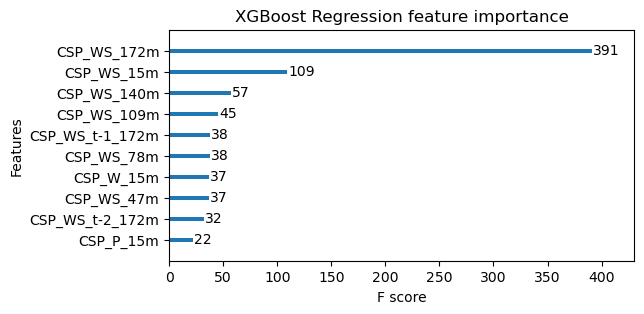

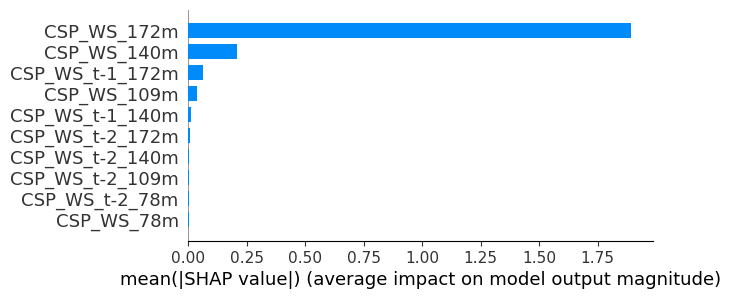

height: 234 m

MSE:
XGBoost: 0.00175
random forest: 0.02061
power law:  7e-05


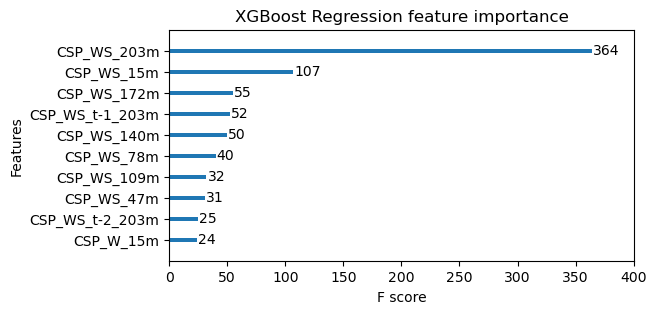

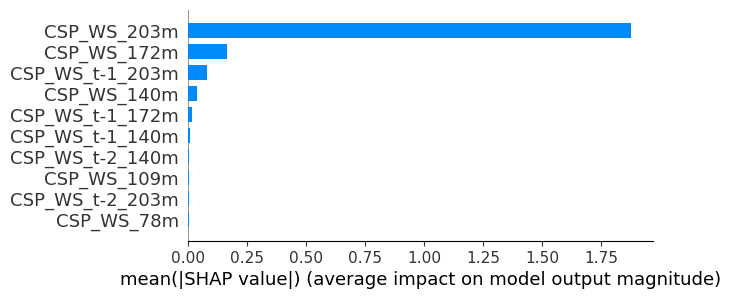

#################### wrfstat6 ####################

height: 77 m

MSE:
XGBoost: 0.00649
random forest: 0.05582
power law:  1.00709


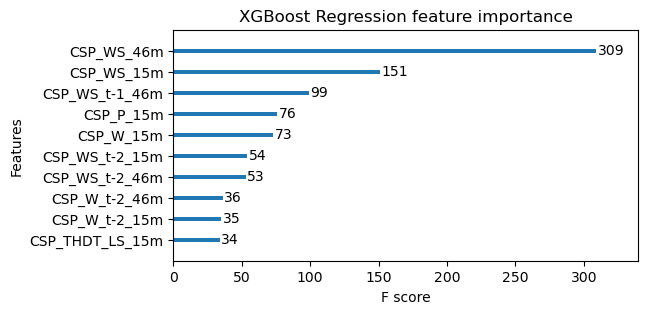

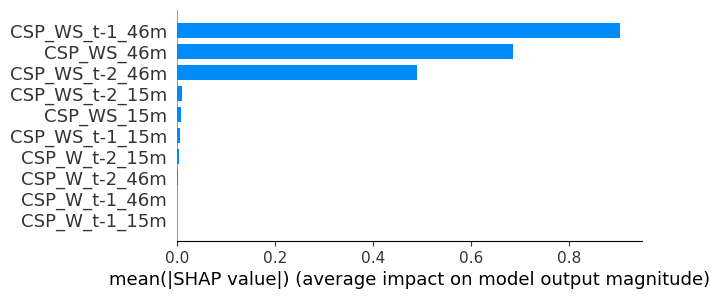

height: 108 m

MSE:
XGBoost: 0.00385
random forest: 0.03088
power law:  0.02295


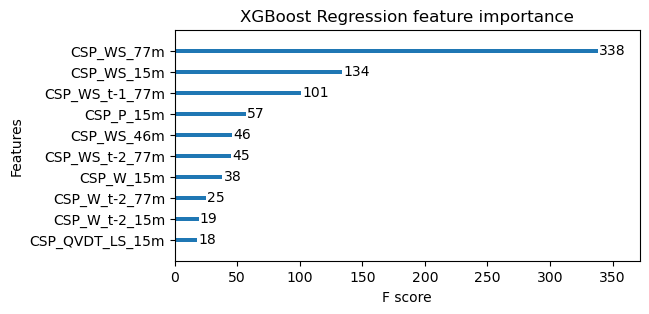

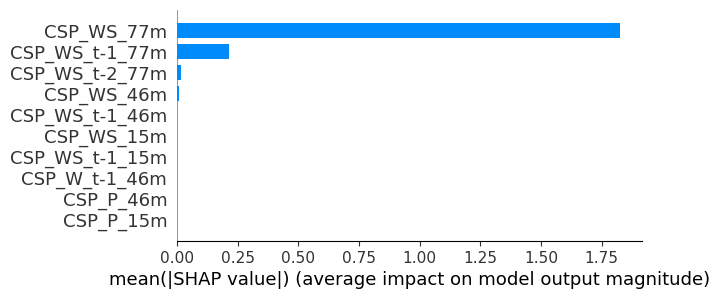

height: 139 m

MSE:
XGBoost: 0.00296
random forest: 0.0276
power law:  0.00227


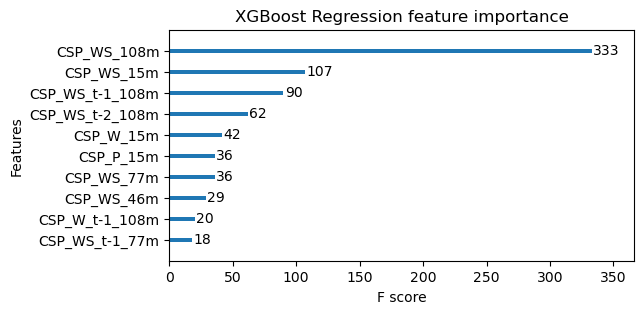

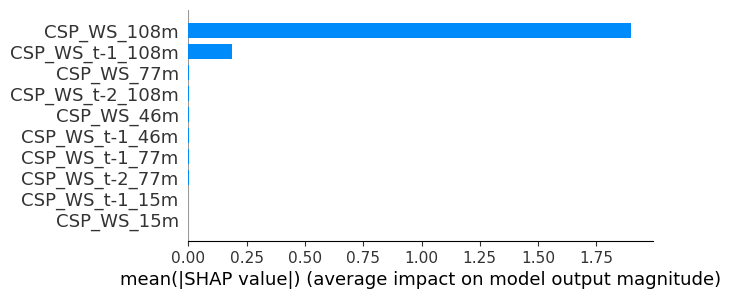

height: 170 m

MSE:
XGBoost: 0.00254
random forest: 0.02859
power law:  0.00051


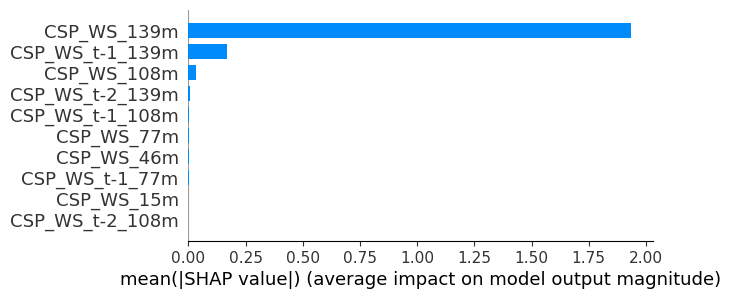

height: 200 m

MSE:
XGBoost: 0.00238
random forest: 0.02871
power law:  0.00028


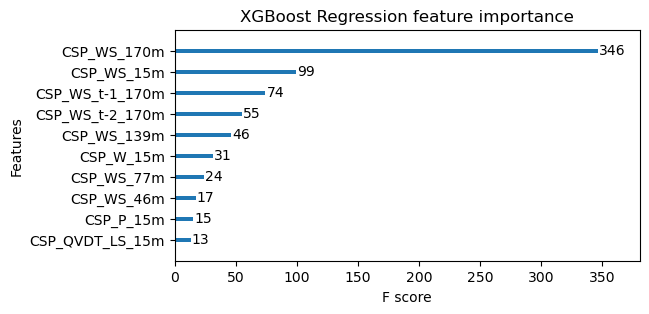

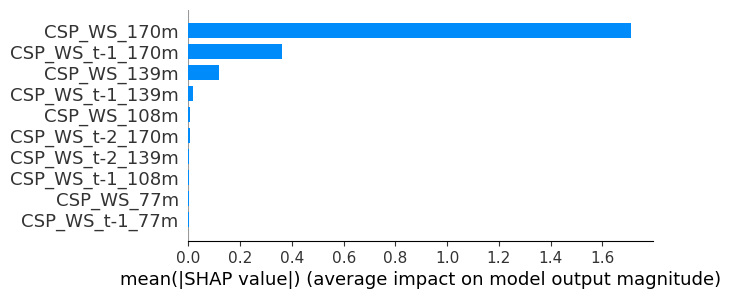

height: 231 m

MSE:
XGBoost: 0.00212
random forest: 0.02591
power law:  0.00021


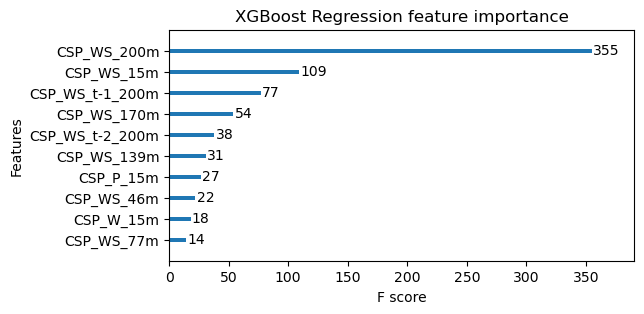

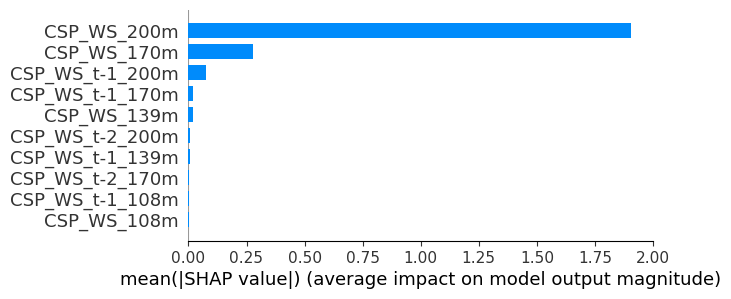

#################### wrfstat7 ####################

height: 77 m

MSE:
XGBoost: 0.00496
random forest: 0.04992
power law:  0.82342


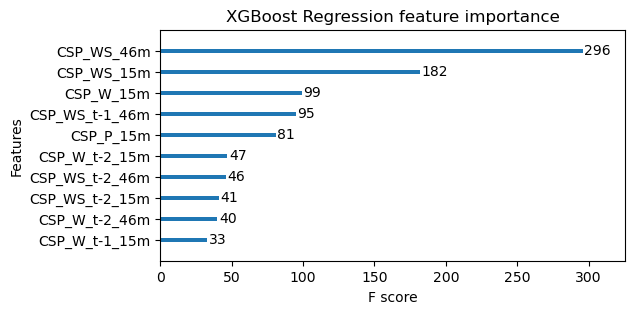

height: 108 m

MSE:
XGBoost: 0.00277
random forest: 0.02707
power law:  0.02056


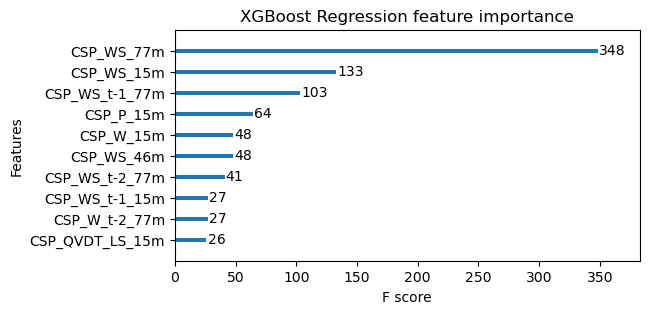

height: 139 m

MSE:
XGBoost: 0.00203
random forest: 0.02154
power law:  0.0021


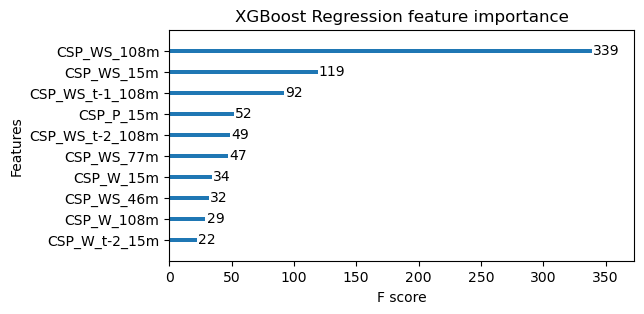

height: 170 m

MSE:
XGBoost: 0.00146
random forest: 0.02279
power law:  0.00046


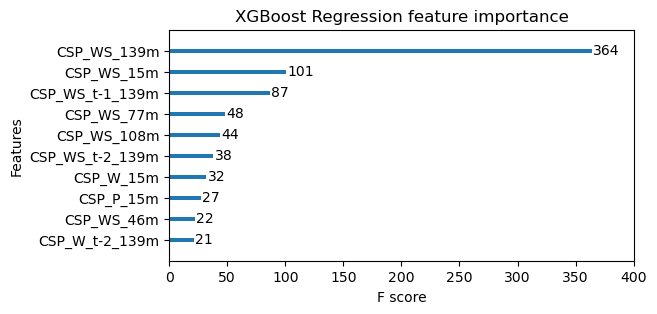

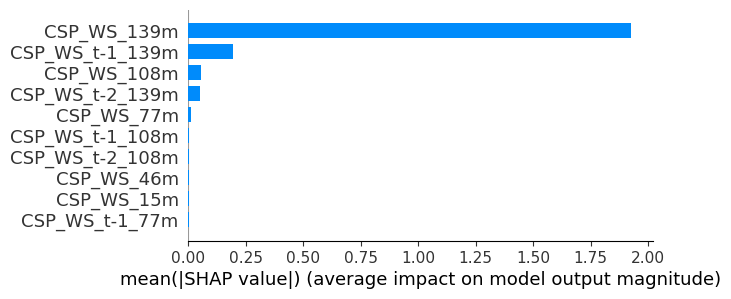

height: 200 m

MSE:
XGBoost: 0.00149
random forest: 0.02
power law:  0.00028


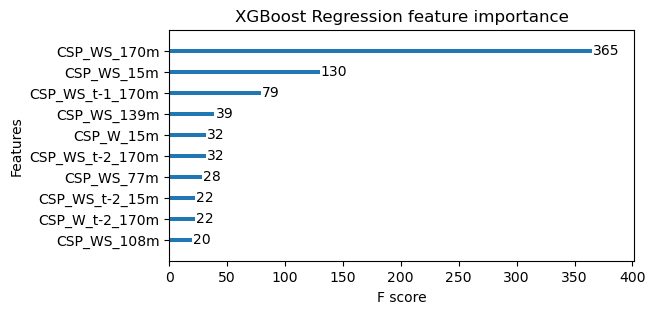

height: 231 m

MSE:
XGBoost: 0.00134
random forest: 0.02001
power law:  0.00013


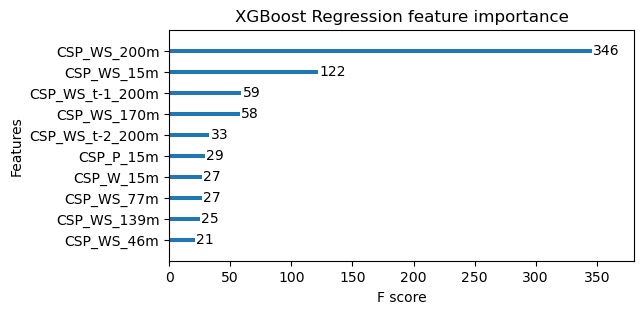

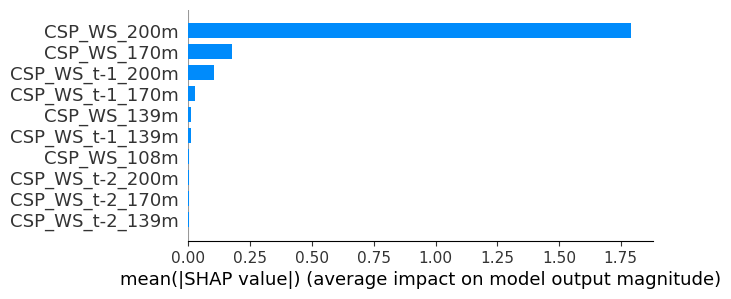

#################### wrfstat8 ####################

height: 78 m

MSE:
XGBoost: 0.00501
random forest: 0.05023
power law:  0.92075


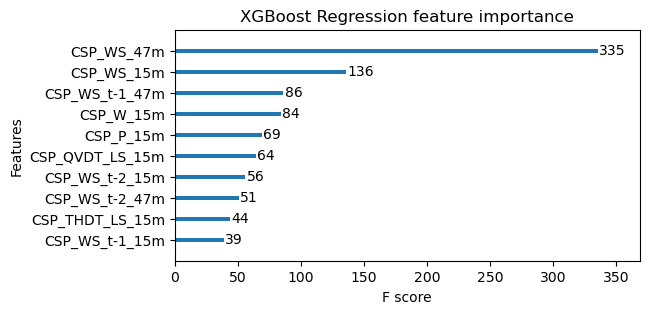

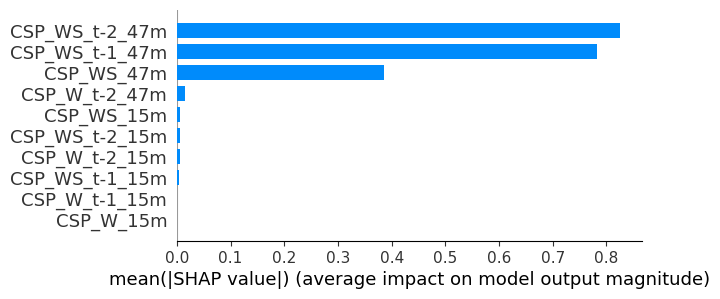

height: 109 m

MSE:
XGBoost: 0.00264
random forest: 0.02342
power law:  0.02331


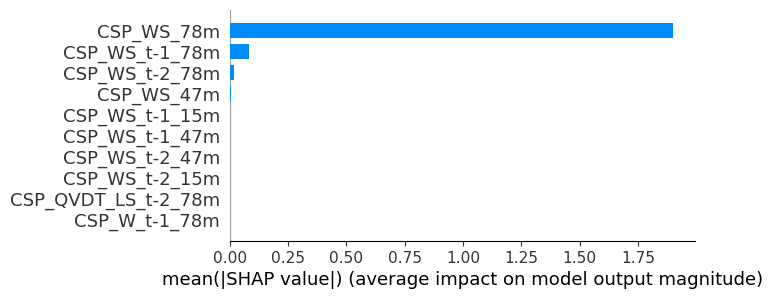

height: 139 m

MSE:
XGBoost: 0.00161
random forest: 0.02018
power law:  0.00206


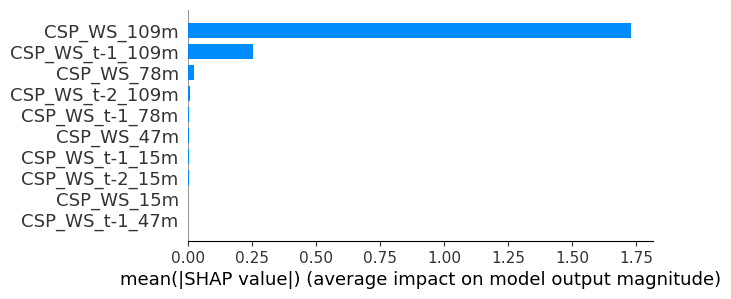

height: 170 m

MSE:
XGBoost: 0.00131
random forest: 0.0198
power law:  0.0007


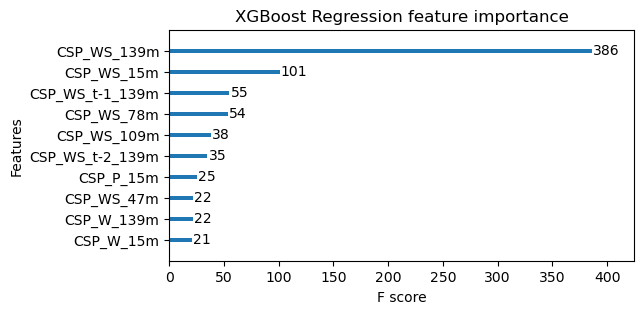

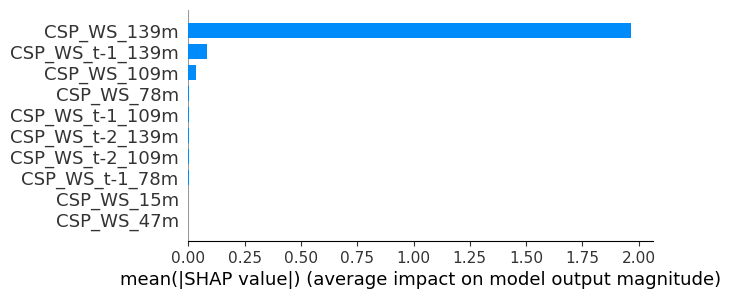

height: 201 m

MSE:
XGBoost: 0.00126
random forest: 0.01705
power law:  0.0002


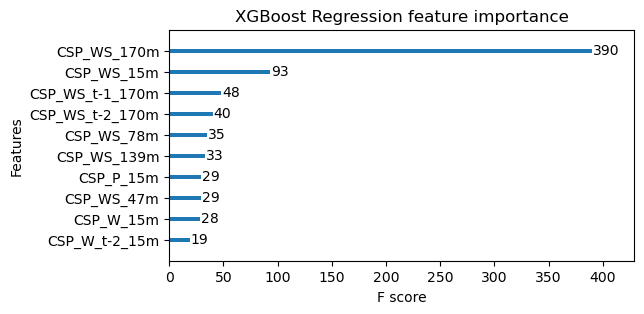

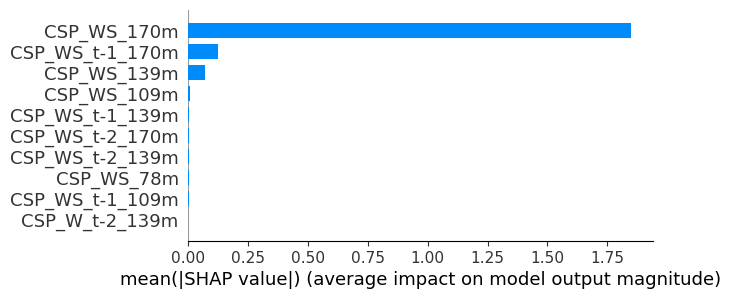

height: 231 m

MSE:
XGBoost: 0.00116
random forest: 0.01642
power law:  7e-05


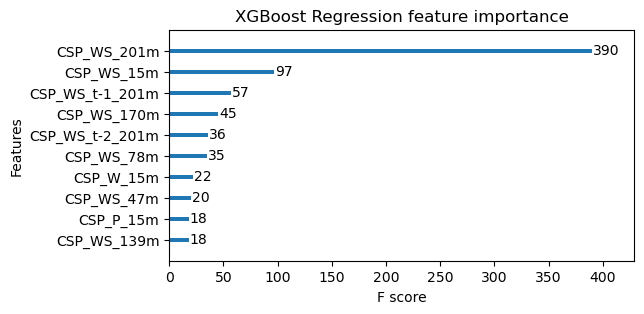

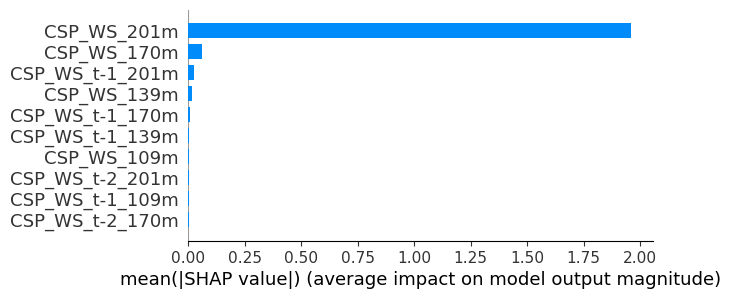

In [3]:
summary_df = pd.DataFrame()

wrf_dic = {1: 'no-forcing', 2: 'varnal-300', 3: 'ecmwf-16', 4: 'ecmwf-114', 
           5: 'ecmwf-413', 6: 'msda-75', 7: 'msda-150', 8: 'msda-300'}

for file_num in np.arange(8)+1:

    features_df, hgt_list = get_features(file_num, lev_i)
    
    dum_df = pd.DataFrame()

    # start extrapolation at 3rd level
    for h in hgt_list[2:]:
        
        mse_xgbr, mse_rf, mse_pl = run_ml(h)
        
        dum_df[int(h)] = mse_xgbr, mse_rf, mse_pl
#         dum_df['wrf'] = 'wrf'+str(file_num)
        dum_df['wrf'] = wrf_dic[file_num]
        dum_df['metric'] = ['xgb', 'rf', 'power law']
        
    summary_df = summary_df.append(dum_df)

In [6]:
summary_df

77      108      139      169      200      231
wrf        metric                                                         
no-forcing xgb        0.00308  0.00130  0.00112  0.00092  0.00073  0.00088
           rf         0.04932  0.02129  0.01841  0.01839  0.01736  0.01802
           power law  1.21862  0.02662  0.00186  0.00029  0.00022  0.00007
varnal-300 xgb        0.00351  0.00125  0.00121  0.00090  0.00091  0.00084
           rf         0.04176  0.02336  0.01962  0.02286  0.02232  0.02126
           power law  0.80062  0.02623  0.00268  0.00043  0.00017  0.00006
ecmwf-16   xgb        0.00416  0.00218  0.00190  0.00177  0.00156  0.00161
           rf         0.04799  0.02341  0.02304  0.02262  0.01991  0.01882
           power law  0.98558  0.02621  0.00213  0.00043  0.00016  0.00008
ecmwf-114  xgb        0.00301  0.00188  0.00180  0.00154  0.00115  0.00111
           rf         0.04362  0.02284  0.02147  0.01813  0.01935  0.01841
           power law  0.82570  0.02475  0.00197  0.00059  0.00016  0.00006
ecmwf-413  xgb        0.00395  0.00223  0.00199  0.00200  0.00197  0.00175
           rf         0.03866  0.02092  0.02035  0.02157  0.02036  0.02061
           power law  0.63695  0.02217  0.00196  0.00050  0.00011  0.00007
msda-75    xgb        0.00649  0.00385  0.00296  0.00254  0.00238  0.00212
           rf         0.05582  0.03088  0.02760  0.02859  0.02871  0.02591
           power law  1.00709  0.02295  0.00227  0.00051  0.00028  0.00021
msda-150   xgb        0.00496  0.00277  0.00203  0.00146  0.00149  0.00134
           rf         0.04992  0.02707  0.02154  0.02279  0.02000  0.02001
           power law  0.82342  0.02056  0.00210  0.00046  0.00028  0.00013
msda-300   xgb        0.00501  0.00264  0.00161  0.00131  0.00126  0.00116
           rf         0.05023  0.02342  0.02018  0.01980  0.01705  0.01642
           power law  0.92075  0.02331  0.00206  0.00070  0.00020  0.00007

In [5]:
summary_df = summary_df.set_index(['wrf', 'metric'])

# standardize wrfstat heights
for col in summary_df.columns:    
    
    for diff in np.arange(3)+1:
    
        if col+diff in summary_df.columns:
    
            summary_df[col] = summary_df[col].fillna(summary_df[col+diff])
    
summary_df.dropna(axis=1, inplace=True)

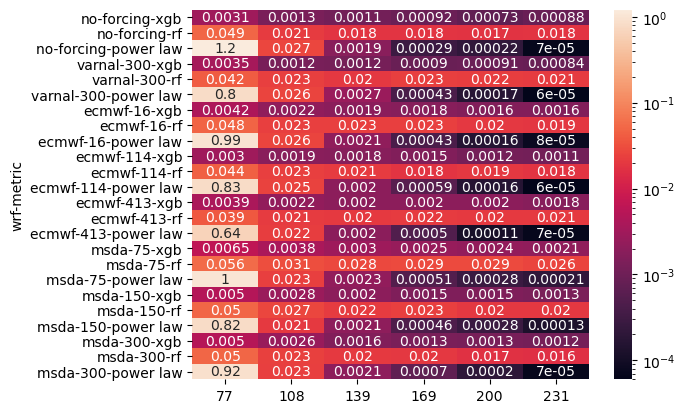

In [7]:
sns.heatmap(summary_df, norm=matplotlib.colors.LogNorm(), annot=True)
plt.show()

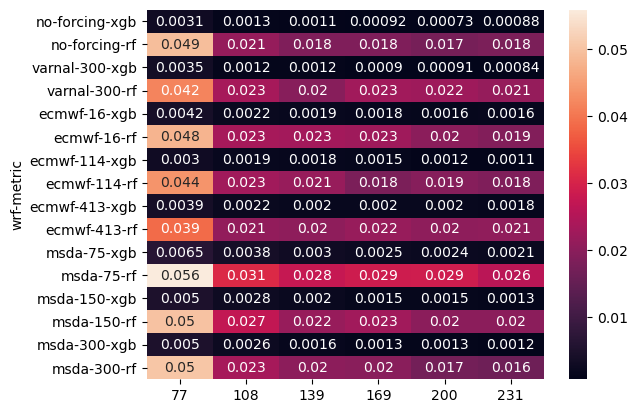

In [22]:
sns.heatmap(summary_df[summary_df.index.get_level_values(1).str.contains('power') == False], 
            annot=True)
plt.show()

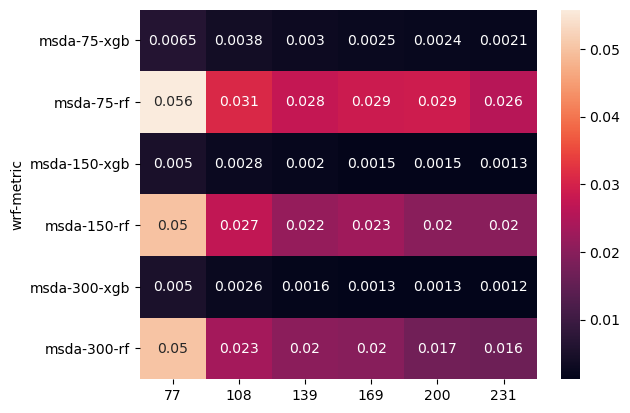

In [24]:
sns.heatmap(summary_df[(summary_df.index.get_level_values(1).str.contains('power') == False) & 
                       (summary_df.index.get_level_values(0).str.contains('msda') == True)], 
            annot=True)
plt.show()

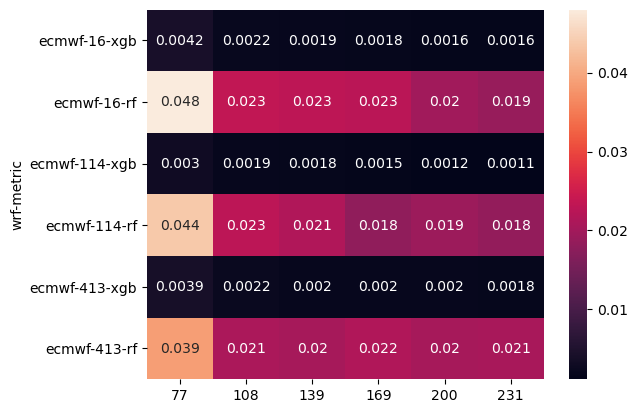

In [9]:
sns.heatmap(summary_df.loc[(['ecmwf-16', 'ecmwf-114', 'ecmwf-413'], ['xgb', 'rf']), :], annot=True)
plt.show()